# Sub-graphs

## Review

In the past 3 modules, we've built an understanding of LangGraph fundementals, agent fundementals, state, memory, and human-in-the-loop!

## Context

Now, let's bring them togther in a practical example that does two things:

* Leverages a wide set of LangGraph capabilities
* Is generally interesting and fun

With fall around the corner, in the United States espectially football is popular. [Fantasy Football](https://fantasy.nfl.com/) is a popular online game where participants act as managers of virtual professional football teams. The goal is to assemble a team of real-life NFL players and score points based on their statistical performance in actual games.

We have a small league in our office, and I wanted to create a `take-bot` that can:

* Ingest a few different sources of information (e.g., on an ongoing basis)
* Analyze it (e.g., in parallel)
* Produce small, bit-sized `takes` related to teams in our league and / or general play of specific players
* Write to a public Slack in our office

So, we'll built this in LangGraph!

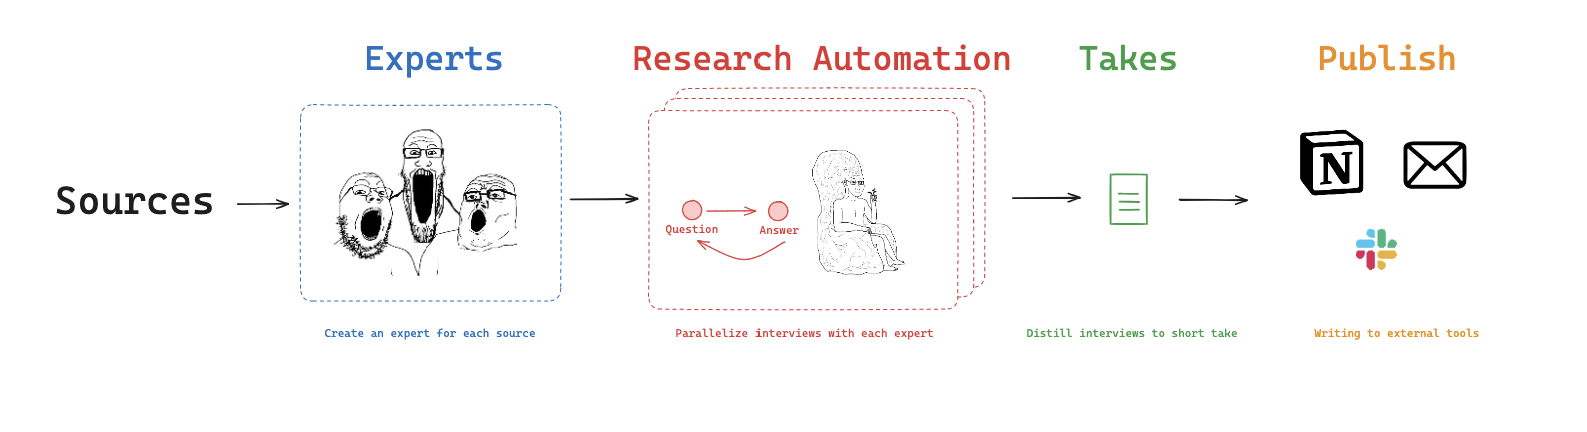

--- 

While it's a fun and silly use-case, it ties together advanced LangGraph features and some more serious themes we see:

1) `Report Generation` -- [Reports provide greater value than question-answering tools used in many RAG systems](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/). This is because reports offer more than just answers; they are more refined tools for decision-making. Reports can save costs by replacing the need for multiple employees or expensive processes.

2) `Automating multi-step research workflows` -- There are some interesting examples of AI-mediated workflows that replace knowlege work. For example, [deal flow automation for VCs](https://x.com/MaxBrodeurUrbas/status/1806380947606253960) that analyzes pitch decks (e.g., extracts all metrics, finds founder LinkedIns + extracts their background, writes to Notion).

3) `Multi-perspective AI assistants` -- A generally powerful approach, as seen in papers like [STORM](https://github.com/langchain-ai/langgraph/blob/main/examples/storm/storm.ipynb), is to create AI assistants that take on various roles and have them simultanously research about a topic from different angles.

## Goals

First, we'll lay out the basics of our take-bot agent.
 
We'll introduce the idea of sub-graphs.
 
[Sub-graphs](https://langchain-ai.github.io/langgraph/how-tos/subgraph/) allow you to create parts of your graph that have their own state.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai praw

## Gather expert sources

First, let's gather sources that we want our experts to use. 

This is very flexible! We'll use [the Reddit Fantasy Football sub](https://www.reddit.com/r/fantasyfootball/comments/1espdv7/who_is_one_guy_you_arent_leaving_the_draft/), to start.

In [15]:
import os
import praw

# Reddit creds
reddit_client_id = os.getenv('REDDIT_CLIENT_ID')
reddit_client_secret = os.getenv('REDDIT_CLIENT_SECRET')

# Initialize the Reddit instance
reddit = praw.Reddit(client_id=reddit_client_id,
                     client_secret=reddit_client_secret,
                     user_agent='Fantasy Football Loader')

def get_reddit_post(url):
    ''' Get reddit post comments '''

    # Fetch the submission
    submission = reddit.submission(url=url)
    
    # Load the comments
    submission.comments.replace_more(limit=None)
    comments = submission.comments.list()
    
    # Concatenate comments into a single string
    reddit_context = "\n *** user commnent *** \n".join([comment.body for comment in comments])
    return reddit_context

# Context for experts 
draft_strategy_context = get_reddit_post("https://www.reddit.com/r/fantasyfootball/comments/1ewk6kr/theres_only_one_draft_strategy_that_ill_ever/")
top_player_context = get_reddit_post("https://www.reddit.com/r/fantasyfootball/comments/1espdv7/who_is_one_guy_you_arent_leaving_the_draft/")

## Create experts

LLM that the experts will use to answer questions.

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

Schema for each expert.

In [33]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

class Expert(BaseModel):
    name: str = Field(
        description="Name of the expert.", pattern=r"^[a-zA-Z0-9_-]{1,64}$"
    )
    role: str = Field(
        description="Role of the expert.",
    )
    context: SystemMessage = Field(
        description="Instructions used by the expert.",
    )

    def answer(self, dicussion: List) -> AIMessage:
        return llm.invoke([self.context]+dicussion)

Schema for the final `takes` resulting from discussion with the expert.

In [68]:
class Take(BaseModel):
    title: str = Field(
        description="Punchy summary title for the take or perspective",
    )
    take: str = Field(
        description="Fun, punchy observation from the discussion between expert and interviewer.",
    )

class Takes(BaseModel):
    takes: List[Take] = Field(
        description="A list of takes, each containing a title and a take observation."
    )

Overall graph state.

In [58]:
import operator

class OverallState(InterviewOutputState):
    topic: str
    experts: List[Expert]
    takes: Annotated[List[Take], operator.add]

Generate our experts.

In [90]:
from langchain_core.runnables import chain as as_runnable

@as_runnable
def generate_experts(state: OverallState):
    """ Generate our experts """
    
    preamble = "You are an expert in in Fantasy Football. You are being interviewed by an analyst. Don't make up your own answers."
    
    draft_strategy_expert = Expert(
        name="Moe",
        role="Fantasy Draft Strategy Expert",
        context=SystemMessage(content=f"{preamble} Use only this information to answer questions from the analyst: {draft_strategy_context}"),
    )
    
    top_player_expert = Expert(
        name="Jimbo",
        role="Top Players To Draft Expert",
        context=SystemMessage(content=f"{preamble} Use only this information to answer questions from the analyst: {top_player_context}"),
    )

    return {"experts": [draft_strategy_expert, top_player_expert]}

In [91]:
# Test this! 
topic = "A thesis for top players to draft in Fantasy Football."
experts = generate_experts.invoke({"topic":topic})

## Create interview sub-graph

Define an `inner state` for the interview sub-graph.

We call this an `inner state` because it will differ from the `outer state`, the `OverallState` for our overall graph. 

In particular, it will contain a few keys that we don't need in the `outer state`.

In [127]:
from langgraph.graph import MessagesState

max_num_turns = 4

class InterviewState(MessagesState):
    topic: str
    expert: Expert
    
class InterviewOutputState(TypedDict):
     takes: List[Take]

We'll simulate an interview between each expert and an interviewer.

Generate question from interviewer.

In [106]:
@as_runnable
def generate_question(state: InterviewState):
    """Node to generate a question """

    instructions = SystemMessage(content=f"""
    
    You are an analyst tasked with interviewing an expert to learn about a specific topic. 
    
    Here is your topic: {state["topic"]}
    
    1. Interesting: Insights that people will find surprising or non-obvious.
    
    2. Specific: Insights that avoid generalities and include specific examples from the expert.
    
    Begin by introducing yourself, and then ask your question.
    
    Continue to ask questions to drill down and refine your understanding of the topic.
    
    As the interview proceeds for a bit, assess your understanding.
    
    If you are satisfied, then complete the interview with: "Thank you so much for your help!"
    
    Remember to stay in character throughout your response, reflecting the persona and goals provided to you.""")
    
    # Generate question 
    result = llm.invoke([instructions]+state["messages"])   
    
    # Write messages to state
    return {"messages": [HumanMessage(content=result.content,name='Interviewer')]}

Use expert to answer question.

In [107]:
@as_runnable
def generate_answer(state: InterviewState):
    """ Node to answer a question """

    messages = state["messages"]
    expert = state["expert"]
   
    # Answer question
    answer = expert.answer(messages)
    
    # Use this to track expert responses
    answer.name = 'expert'
    
    # Append it to state
    return {"messages": [answer]}

Use `structured output` to generate takes.

In [128]:
@as_runnable
def generate_takes(state: InterviewState):
    """ Node to answer a question """

    # Get discussion
    messages = state["messages"]

    # Instructions
    instructions = SystemMessage(content=f"""Distill the conversation between the analyst and expert into a set of fun, punchy takes. Use specific players / examples in your takes to liven then up and keep them specific.""")

    # Structured output
    structured_llm = llm.with_structured_output(Takes)
    
    # Answer question
    takes = structured_llm.invoke([instructions]+messages)
        
    # Append it to state
    return {"takes": takes}

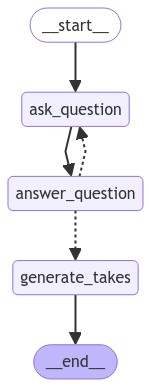

In [124]:
from IPython.display import Image, display
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return "generate_takes"

    # This router is run after each question - answer pair 
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return "generate_takes"
    return "ask_question"

# Add nodes and edges 
interview_builder = StateGraph(input=InterviewState,output=InterviewOutputState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("generate_takes", generate_takes)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','generate_takes'])
interview_builder.add_edge("generate_takes", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory)

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [125]:
thread = {"configurable": {"thread_id": "4"}}
result = interview_graph.invoke({"topic":topic, "expert":experts['experts'][0]}, thread)

In [126]:
from IPython.display import Markdown, display
for take in result['takes'].takes:
    display(Markdown(f"### {take.title}\n{take.take}\n"))

### Trust Your Gut Over ADP
Fantasy managers who trusted their instincts and drafted Cooper Kupp earlier than his ADP in 2021 were handsomely rewarded with a historic season.


### Josh Jacobs' Redemption Arc
Despite negative buzz and a dropping ADP, those who believed in Josh Jacobs in 2022 reaped the benefits as he finished as one of the top running backs.


### Opportunity is King
Metrics like snap counts and target share are crucial; players with more opportunities on the field are more likely to produce big numbers.


### Scheme Changes Matter
A new offensive coordinator can significantly impact a player's usage, making it essential to monitor coaching changes.


### Injury Insights
Players coming off injuries might be undervalued but can provide significant value if fully recovered—keep an eye on those injury reports.


### Efficiency Metrics
Advanced stats like yards per route run (YPRR) and yards after contact (YAC) can help identify players who are performing well even if their raw stats don't show it yet.


### Strength of Schedule
A favorable schedule during the fantasy playoffs can make a player a difference-maker—don't overlook this when drafting.


### Training Camp Buzz
Stay updated with training camp and preseason reports; beat writers often provide valuable insights into which players are standing out.


### Contract Year Motivation
Players in the final year of their contract often have extra motivation to perform well, potentially leading to breakout performances.


## Overall graph

Note that when we run:
```
overall_builder.add_node("conduct_interview", interview_builder.compile())
```

We compile the sub-graph with its own `InterviewState` as part of the overall graph!

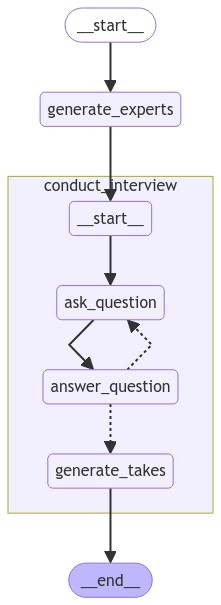

In [114]:
# Add nodes and edges 
overall_builder = StateGraph(OverallState)

# Add nodes and edges 
overall_builder.add_node("generate_experts", generate_experts)
overall_builder.add_node("conduct_interview", interview_builder.compile())

overall_builder.add_edge(START, "generate_experts")
overall_builder.add_edge("generate_experts", "conduct_interview")
overall_builder.add_edge("conduct_interview", END)
graph = overall_builder.compile()

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))